## Description:
这里我们尝试建立一个PNN网络来完成一个ctr预测的问题。 关于Pytorch的建模流程， 主要有四步：
1. 准备数据
2. 建立模型
3. 训练模型
4. 使用和保存


## 导入包

In [124]:
import datetime
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchkeras import summary#, Model

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [125]:
# 导入数据， 数据已经处理好了 preprocess/下
train_set = pd.read_csv('preprocessed_data/train_set.csv')
val_set = pd.read_csv('preprocessed_data/val_set.csv')
test_set = pd.read_csv('preprocessed_data/test.csv')

In [126]:
train_set.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,0.0,0.000381,0.000473,0.000000,0.009449,0.082147,0.004825,0.003656,0.040447,0.0,...,166,116,2,14,0,0,60,27,327,0
1,0.0,0.000127,0.000000,0.000000,0.075768,0.000000,0.000000,0.000000,0.000710,0.0,...,145,0,0,1166,0,1,469,0,0,0
2,0.0,0.000381,0.000236,0.137931,0.004804,0.030185,0.007841,0.062157,0.024126,0.0,...,99,0,0,588,0,11,434,0,0,0
3,0.0,0.011696,0.000473,0.034483,0.002180,0.000000,0.000000,0.032907,0.003193,0.0,...,188,34,1,862,0,0,67,27,380,1
4,0.0,0.004450,0.001064,0.034483,0.006119,0.039457,0.001206,0.009141,0.000887,0.0,...,348,0,0,296,0,9,23,0,0,0


In [127]:
# 这里需要把特征分成数值型和离散型， 因为后面的模型里面离散型的特征需要embedding， 而数值型的特征直接进入了stacking层， 处理方式会不一样
data_df = pd.concat((train_set, val_set, test_set))

dense_feas = ['I'+str(i) for i in range(1, 14)]
sparse_feas = ['C'+str(i) for i in range(1, 27)]

# 定义一个稀疏特征的embedding映射， 字典{key: value}, key表示每个稀疏特征， value表示数据集data_df对应列的不同取值个数， 作为embedding输入维度
sparse_feas_map = {}
for key in sparse_feas:
    sparse_feas_map[key] = data_df[key].nunique()

In [128]:
sparse_feas_map

{'C1': 79,
 'C2': 252,
 'C3': 1293,
 'C4': 1043,
 'C5': 30,
 'C6': 7,
 'C7': 1164,
 'C8': 39,
 'C9': 2,
 'C10': 908,
 'C11': 926,
 'C12': 1239,
 'C13': 824,
 'C14': 20,
 'C15': 819,
 'C16': 1159,
 'C17': 9,
 'C18': 534,
 'C19': 201,
 'C20': 4,
 'C21': 1204,
 'C22': 7,
 'C23': 12,
 'C24': 729,
 'C25': 33,
 'C26': 554}

In [129]:
feature_info = [dense_feas, sparse_feas, sparse_feas_map]  # 这里把特征信息进行封装， 建立模型的时候作为参数传入

## 准备数据 

In [130]:
# 把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(train_set.drop(columns='Label').values).float(), torch.tensor(train_set['Label']).float())
dl_val_dataset = TensorDataset(torch.tensor(val_set.drop(columns='Label').values).float(), torch.tensor(val_set['Label']).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=16)
dl_vaild = DataLoader(dl_val_dataset, shuffle=True, batch_size=16)

In [131]:
# 查看一下数据
for b in iter(dl_train):             # b是一个list
    print(b[0].shape, b[1].shape)
    break

torch.Size([16, 39]) torch.Size([16])


## 建立模型
建立模型有三种方式：
1. 继承nn.Module基类构建自定义模型
2. nn.Sequential按层顺序构建模型
3. 继承nn.Module基类构建模型， 并辅助应用模型容器进行封装

这里我们依然会使用第三种方式， 因为embedding依然是很多层。 模型的结构如下：

![](img/pnn.png)

这里简单的分析一下这个模型， 说几个比较重要的细节：
1. 这里的输入， 由于都进行了embedding， 所以这里应该是类别型的特征， 关于数值型的特征， 在把类别都交叉完了之后， 才把数值型的特征加入进去
2. 交叉层这里， 左边和右边其实用的同样的一层， 有着同样的神经单元个数， 只不过这里进行计算的时候， 得分开算，左边的是单个特征的线性组合lz， 而右边是两两特征进行交叉后特征的线性组合lp。 得到这两个之后， 两者进行相加得到最终的组合， 然后再relu激活才是交叉层的输出。
3. 交叉层这里图上给出的是**一个神经元**内部的计算情况， 注意这里是一个神经元内部的计算， 这些圈不是表示多个神经元。

下面说一下代码的逻辑：
1. 首先， 我们定义一个DNN神经网络， 这个也就是上面图片里面的交叉层上面的那一部分结构， 也就是很多个全连接层的一个网络， 之所以单独定义这样的一个网络， 是因为更加的灵活， 加多少层， 每层神经元个数是多少我们就可以自己指定了， 这里会涉及到一个小操作技巧。
2. 然后就是定义整个PNN网络， 核心部分就是在前向传播。

In [132]:
# python生成元素对测试， 这个可以帮助我们定义一个列表的全连接层
a = [512, 256, 128, 64]
list(zip(a[:-1], a[1:]))

[(512, 256), (256, 128), (128, 64)]

In [133]:
# 定义一个全连接层的神经网络
class DNN(nn.Module):
    
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units:列表， 每个元素表示每一层的神经单元个数，比如[256, 128, 64]，两层网络， 第一层神经单元128个，第二层64，注意第一个是输入维度
        dropout: 失活率
        """
        super(DNN, self).__init__()
        
        # 下面创建深层网络的代码 由于Pytorch的nn.Linear需要的输入是(输入特征数量， 输出特征数量)格式， 所以我们传入hidden_units， 
        # 必须产生元素对的形式才能定义具体的线性层， 且Pytorch中线性层只有线性层， 不带激活函数。 这个要与tf里面的Dense区分开。
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p=dropout)
    
    # 前向传播中， 需要遍历dnn_network， 不要忘了加激活函数
    def forward(self, x):
        
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)  #激活函数
        
        x = self.dropout(x)
        
        return x

In [134]:
# 测试一下这个网络
hidden_units = a = [512, 256, 128, 64]        # 层数和每一层神经单元个数， 由我们自己定义了
dnn = DNN(hidden_units)
summary(dnn, input_shape=(512,))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                   [-1, 256]              131,328
Linear-2                                   [-1, 128]               32,896
Linear-3                                    [-1, 64]                8,256
Dropout-4                                   [-1, 64]                    0
Total params: 172,480
Trainable params: 172,480
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.001953
Forward/backward pass size (MB): 0.003906
Params size (MB): 0.657959
Estimated Total Size (MB): 0.663818
--------------------------------------------------------------------------


'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nLinear-1                                   [-1, 256]              131,328\nLinear-2                                   [-1, 128]               32,896\nLinear-3                                    [-1, 64]                8,256\nDropout-4                                   [-1, 64]                    0\n==========================================================================\nTotal params: 172,480\nTrainable params: 172,480\nNon-trainable params: 0\n--------------------------------------------------------------------------\nInput size (MB): 0.001953\nForward/backward pass size (MB): 0.003906\nParams size (MB): 0.657959\nEstimated Total Size (MB): 0.663818\n--------------------------------------------------------------------------'

In [135]:
class ProductLayer(nn.Module):
    
    def __init__(self, mode, embed_dim, field_num, hidden_units):
        
        super(ProductLayer, self).__init__()
        self.mode = mode
        # product层， 由于交叉这里分为两部分， 一部分是单独的特征运算， 也就是上面结构的z部分， 一个是两两交叉， p部分， 而p部分还分为了内积交叉和外积交叉
        # 所以， 这里需要自己定义参数张量进行计算
        # z部分的w， 这里的神经单元个数是hidden_units[0], 上面我们说过， 全连接层的第一层神经单元个数是hidden_units[1]， 而0层是输入层的神经
        # 单元个数， 正好是product层的输出层  关于维度， 这个可以看在博客中的分析
        self.w_z = nn.Parameter(torch.rand([field_num, embed_dim, hidden_units[0]]))    # 即D1
        
        # p部分, 分内积和外积两种操作
        if mode == 'in':
            self.w_p = nn.Parameter(torch.rand([field_num, field_num, hidden_units[0]]))
        else:
            self.w_p = nn.Parameter(torch.rand([embed_dim, embed_dim, hidden_units[0]]))
        
        self.l_b = torch.rand([hidden_units[0], ], requires_grad=True)
    
    def forward(self, z, sparse_embeds):
        # lz部分  先reshape为二维矩阵
        l_z = torch.mm(z.reshape(z.shape[0], -1), self.w_z.permute((2, 0, 1)).reshape(self.w_z.shape[2], -1).T)# (None, hidden_units[0])
        
        # lp 部分
        if self.mode == 'in':  # in模式  内积操作  p就是两两embedding先内积得到的[field_dim, field_dim]的矩阵
            p = torch.matmul(sparse_embeds, sparse_embeds.permute((0, 2, 1)))  # [None, field_num, field_num]
        else:  # 外积模式  这里的p矩阵是两两embedding先外积得到n*n个[embed_dim, embed_dim]的矩阵， 然后对应位置求和得到最终的1个[embed_dim, embed_dim]的矩阵
            # 所以这里实现的时候， 可以先把sparse_embeds矩阵在field_num方向上先求和， 然后再外积
            f_sum = torch.unsqueeze(torch.sum(sparse_embeds, dim=1), dim=1)  # [None, 1, embed_dim]
            p = torch.matmul(f_sum.permute((0,2,1)), f_sum)     # [None, embed_dim, embed_dim]
        
        l_p = torch.mm(p.reshape(p.shape[0], -1), self.w_p.permute((2, 0, 1)).reshape(self.w_p.shape[2], -1).T)  # [None, hidden_units[0]]
        
        output = l_p + l_z + self.l_b
        return output

In [136]:
# 下面我们定义真正的PNN网络
# 这里的逻辑是底层输入（类别型特征) -> embedding层 -> product 层 -> DNN -> 输出
class PNN(nn.Module):
    
    def __init__(self, feature_info, hidden_units, mode='in', dnn_dropout=0., embed_dim=10, outdim=1):
        """
        DeepCrossing：
            feature_info: 特征信息（数值特征， 类别特征， 类别特征embedding映射)
            hidden_units: 列表， 全连接层的每一层神经单元个数， 这里注意一下， 第一层神经单元个数实际上是hidden_units[1]， 因为hidden_units[0]是输入层
            dropout: Dropout层的失活比例
            embed_dim: embedding的维度m
            outdim: 网络的输出维度
        """
        super(PNN, self).__init__()
        self.dense_feas, self.sparse_feas, self.sparse_feas_map = feature_info
        self.field_num = len(self.sparse_feas)
        self.dense_num = len(self.dense_feas)
        self.mode = mode
        self.embed_dim = embed_dim
        
         # embedding层， 这里需要一个列表的形式， 因为每个类别特征都需要embedding
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(key): nn.Embedding(num_embeddings=val, embedding_dim=self.embed_dim)
            for key, val in self.sparse_feas_map.items()
        })
        
        # Product层
        self.product = ProductLayer(mode, embed_dim, self.field_num, hidden_units)
        
        # dnn 层
        hidden_units[0] += self.dense_num          #DNN输入层维度 = 类别特征embedding & product后的维度  +  数值特征维度
        self.dnn_network = DNN(hidden_units, dnn_dropout)
        self.dense_final = nn.Linear(hidden_units[-1], 1) #输出层
    
    def forward(self, x):
        dense_inputs, sparse_inputs = x[:, :13], x[:, 13:]   # 数值型和类别型数据分开
        sparse_inputs = sparse_inputs.long()      # 需要转成长张量， 这个是embedding的输入要求格式
        #print(sparse_inputs.shape)
        sparse_embeds = [self.embed_layers['embed_'+key](sparse_inputs[:, i]) for key, i in zip(self.sparse_feas_map.keys(), range(sparse_inputs.shape[1]))]   
        # 上面这个sparse_embeds的维度是 [field_num, None, embed_dim]    
        # none不一定是batchsize，因为dataloader取数据可能没法整除
        print(len(sparse_embeds))   
        print(sparse_embeds[0].shape)
        sparse_embeds = torch.stack(sparse_embeds)
        sparse_embeds = sparse_embeds.permute((1, 0, 2))   # [None, field_num, embed_dim]  注意此时空间不连续， 下面改变形状不能用view，用reshape
        z = sparse_embeds
        
        # product layer
        sparse_inputs = self.product(z, sparse_embeds)
        
        # 把上面的连起来， 注意此时要加上数值特征
        l1 = F.relu(torch.cat([sparse_inputs, dense_inputs], axis=-1))
        # dnn_network
        dnn_x = self.dnn_network(l1)
        
        outputs = F.sigmoid(self.dense_final(dnn_x))
        
        return outputs 

In [137]:
hidden_units = [256, 128, 64]
hidden_units_copy = hidden_units.copy()
net = PNN(feature_info, hidden_units, mode='in')
summary(net, input_shape=(train_set.shape[1],))

26
torch.Size([2, 10])
--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                 [-1, 10]                  790
Embedding-2                                 [-1, 10]                2,520
Embedding-3                                 [-1, 10]               12,930
Embedding-4                                 [-1, 10]               10,430
Embedding-5                                 [-1, 10]                  300
Embedding-6                                 [-1, 10]                   70
Embedding-7                                 [-1, 10]               11,640
Embedding-8                                 [-1, 10]                  390
Embedding-9                                 [-1, 10]                   20
Embedding-10                                [-1, 10]                9,080
Embedding-11                                [-1, 10]                9,260
Embedding-12  

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nEmbedding-1                                 [-1, 10]                  790\nEmbedding-2                                 [-1, 10]                2,520\nEmbedding-3                                 [-1, 10]               12,930\nEmbedding-4                                 [-1, 10]               10,430\nEmbedding-5                                 [-1, 10]                  300\nEmbedding-6                                 [-1, 10]                   70\nEmbedding-7                                 [-1, 10]               11,640\nEmbedding-8                                 [-1, 10]                  390\nEmbedding-9                                 [-1, 10]                   20\nEmbedding-10                                [-1, 10]                9,080\nEmbedding-11          

In [138]:
# 测试一下模型
for fea, label in iter(dl_train):
    print(fea.shape, label.shape)
    out = net(fea)
    print(out)
    break

torch.Size([16, 39]) torch.Size([16])
26
torch.Size([16, 10])
tensor([[9.1687e-11],
        [7.5883e-03],
        [7.4293e-09],
        [3.3067e-09],
        [1.2587e-11],
        [5.0245e-07],
        [5.0373e-09],
        [2.2596e-12],
        [2.1363e-05],
        [3.5632e-06],
        [1.1509e-06],
        [8.6092e-08],
        [1.9874e-11],
        [2.7906e-06],
        [1.7740e-05],
        [8.8672e-11]], grad_fn=<SigmoidBackward>)


## 模型的训练

In [141]:
# 模型的相关设置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)     # 计算AUC， 但要注意如果y只有一个类别的时候， 会报错

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001)
metric_func = auc
metric_name = 'auc'

In [145]:
epochs = 30
log_step_freq = 10

dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print('Start Training...')
nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print('========='*8 + "%s" %nowtime)

for epoch in range(1, epochs+1):
    # 训练阶段
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = net(features)
        predictions = predictions.squeeze(-1)  #使得输出与标签的size一致 否则会报错
        loss = loss_func(predictions, labels)
        try:          # 这里就是如果当前批次里面的y只有一个类别， 跳过去
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    
    # 验证阶段
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_vaild, 1):
        #print(labels.shape)
        with torch.no_grad():
            predictions = net(features)
            predictions = predictions.squeeze(-1)  #使得输出与标签的size一致
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
        
print('Finished Training...')

Start Training...
========================================================================2022-10-12 16:10:31
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 10] loss: 0.424, auc: 0.749
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 20] loss: 0.430, auc: 0.757
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.453, auc: 0.718
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size(

26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 10] loss: 0.387, auc: 0.885
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 20] loss: 0.436, auc: 0.878
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.458, auc: 0.863
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
t

26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 10] loss: 0.443, auc: 0.865
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 20] loss: 0.416, auc: 0.873
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.412, auc: 0.878
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 40] loss: 0.417, auc: 0.884
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([1

26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 10] loss: 0.446, auc: 0.851
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 20] loss: 0.431, auc: 0.866
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.407, auc: 0.866
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 40] loss: 0.376, auc: 0.881
26
torch.Size([1

26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 20] loss: 0.411, auc: 0.914
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.391, auc: 0.921
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 40] loss: 0.377, auc: 0.914
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[ste

26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 10] loss: 0.355, auc: 0.901
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 20] loss: 0.324, auc: 0.931
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.294, auc: 0.939
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 40] loss: 0.307, auc: 0.920
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([1

26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 20] loss: 0.269, auc: 0.932
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.273, auc: 0.943
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 40] loss: 0.263, auc: 0.949
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 50] loss: 0.272, auc: 0.951
26
torch.Size([1

26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 20] loss: 0.223, auc: 0.958
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.212, auc: 0.969
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 40] loss: 0.215, auc: 0.973
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 50] loss: 0.231, auc: 0.975
26
torch.Size([16, 10])
26
torch.Size([1

26
torch.Size([16, 10])
[step = 20] loss: 0.182, auc: 0.991
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.201, auc: 0.982
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 40] loss: 0.209, auc: 0.980
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 50] loss: 0.203, auc: 0.983
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([1

26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 20] loss: 0.310, auc: 0.977
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 30] loss: 0.264, auc: 0.981
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
[step = 40] loss: 0.239, auc: 0.986
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
torch.Size([16, 10])
26
t

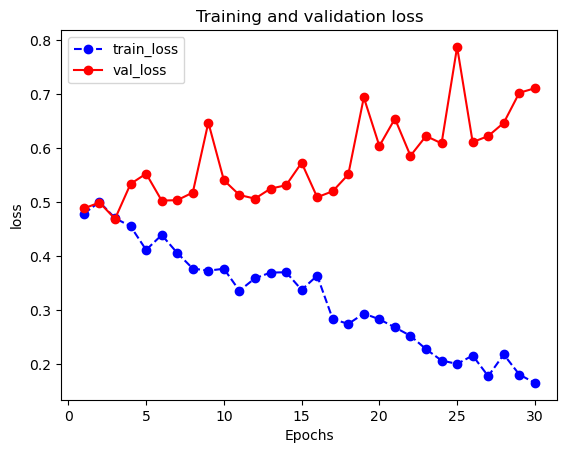

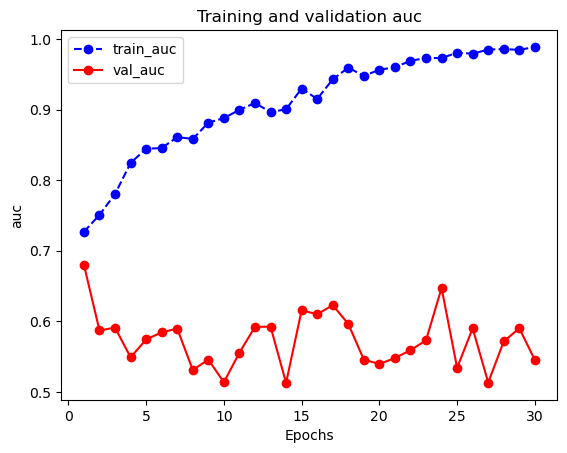

In [146]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [25]:
# 预测
y_pred_probs = net(torch.tensor(test_set.values).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [26]:
y_pred

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
      

In [27]:
# 模型的保存与使用
torch.save(net.state_dict(), './model/net_parameter.pkl')

In [29]:
hidden_units_copy

[256, 128, 64]

In [30]:
net_clone = PNN(feature_info, hidden_units_copy) #faeture_info 保留特征信息 hidden_units_copy 保留DNN结构
net_clone.load_state_dict(torch.load('./model/net_parameter.pkl'))  #定义好模型后加载保存的参数

<All keys matched successfully>

In [31]:
y_pred_probs = net_clone(torch.tensor(test_set.values).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [33]:
y_pred

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
      